In [23]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 18
import matplotlib.patches as mpatches


import settings_gfpkq  as st         # configuration file (update 2/June/22)
import helper as hp   
# Simple Gaussian process class adapted for the emulator
from gaussproc_emu import *

# Linear Pk post training x-check

In [24]:
root_dir = "./"

In [37]:
if st.sigma8:
    #############
    # Load cosmological parameter sets
    # Omega_cdm h^2, Omega_b h^2, sigma8, ns, h
    ###########
    cosmologies = hp.load_arrays(root_dir + 'trainingset','cosmologies_sig8')
    tag="sigma8"
else:
    #############
    # Load cosmological parameter sets
    # Omega_cdm h^2, Omega_b h^2, ln10^10As, ns, h
    ###########
    cosmologies = hp.load_arrays(root_dir + 'trainingset', 'cosmologies_As')
    tag="As"

In [38]:
print(f"Cosmo[{tag}]: nber of training Cosmo points {cosmologies.shape[0]} for {cosmologies.shape[1]} params")

Cosmo[sigma8]: nber of training Cosmo points 1000 for 5 params


In [39]:
#min/max of
# Omega_cdm h^2, Omega_b h^2, sigma8, ns, h    OR
# Omega_cdm h^2, Omega_b h^2, ln10^10As, ns, h

np.min(cosmologies,axis=0), np.max(cosmologies,axis=0)

(array([0.06007758, 0.01900376, 0.25284093, 0.70017789, 0.64001778]),
 array([0.39991897, 0.0259947 , 3.24888822, 1.29993568, 0.8199316 ]))

In [40]:
print(f"Order of polynomial approx: {st.order}")
print(f"Whitening of x_train: {st.x_trans}")
print(f"Transformation of y_tain: {st.gf_args}")
print(f"outputs are centred on zero: {st.use_mean}")
print(f"noise covariance matrix: {st.var}")
print(f"Matrix diag term for stability: { st.jitter}")

Order of polynomial approx: 2
Whitening of x_train: True
Transformation of y_tain: {'y_trans': False, 'lambda_cap': 1}
outputs are centred on zero: False
noise covariance matrix: 1e-05
Matrix diag term for stability: 1e-05


In [41]:
#########
if st.sigma8:
    pk_linear = hp.load_arrays(root_dir + 'trainingset/components_sig8', 'pk_linear')
else:
    pk_linear = hp.load_arrays(root_dir + 'trainingset/components_As', 'pk_linear')
    
print(f"Linear Pk: nber of training points {pk_linear.shape[0]} for {pk_linear.shape[1]} k (log)")
n_pl = pk_linear.shape[1]
assert n_pl == st.nk, "Hummm something strange..."
print(f"The number of GPs to model Pklin={n_pl} (= nber of k_bins) ")

if  st.sigma8:
    folder_pl = root_dir + '/pknl_components' + st.d_one_plus +  '_sig8_RBF' + '/pl'
else:
    folder_pl = root_dir + '/pknl_components' + st.d_one_plus +  '_As' + '/pl'
    
arg_pl = [[cosmologies, pk_linear[:, i], st.pl_args, folder_pl, 'gp_' + str(i)] for i in range(n_pl)]

Linear Pk: nber of training points 1000 for 40 k (log)
The number of GPs to model Pklin=40 (= nber of k_bins) 


# Post training : (emu_i(theta_j) - y_ij)/y_ij

In [42]:
k_scales = []
k_lengthes = []

for i_pl in range(n_pl):
    # for the time beeing re-instance the class each time
    gp_model = GPEmu(kernel=kernel_RBF,
                         order=st.order,
                         x_trans=st.x_trans,
                         y_trans=st.pl_args['y_trans'],
                         use_mean=st.use_mean)
    
    theta = arg_pl[i_pl][0] # cosmo \Theta_i i<N_train
    y = arg_pl[i_pl][1]     # Pk(kj,\Theta_i, z=0)
    arg_cur_gp = arg_pl[i_pl][2]
    arg_cur_gp["folder_name"] = arg_pl[i_pl][3]
    arg_cur_gp["file_name"] = arg_pl[i_pl][4]

    #load training 
    gp_model.load_info(arg_cur_gp["folder_name"],arg_cur_gp["file_name"])
    k_scales.append(gp_model.kernel_hat['k_scale'])
    k_lengthes.append(gp_model.kernel_hat['k_length'])


In [43]:
k_scales=np.array(k_scales)
k_lengthes=np.array(k_lengthes)

In [44]:
k_scales.shape, k_lengthes.shape

((40,), (40, 5))

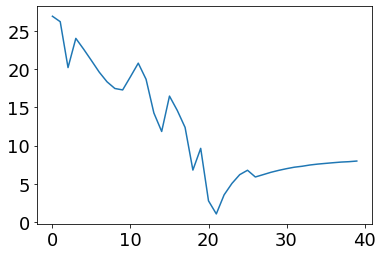

In [45]:
plt.plot(k_scales)

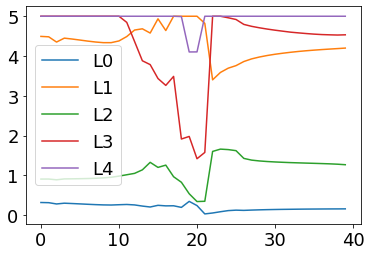

In [46]:
for i in range(k_lengthes.shape[1]):
    plt.plot(np.log(k_lengthes[:,i]),label=f"L{i}")
plt.legend();

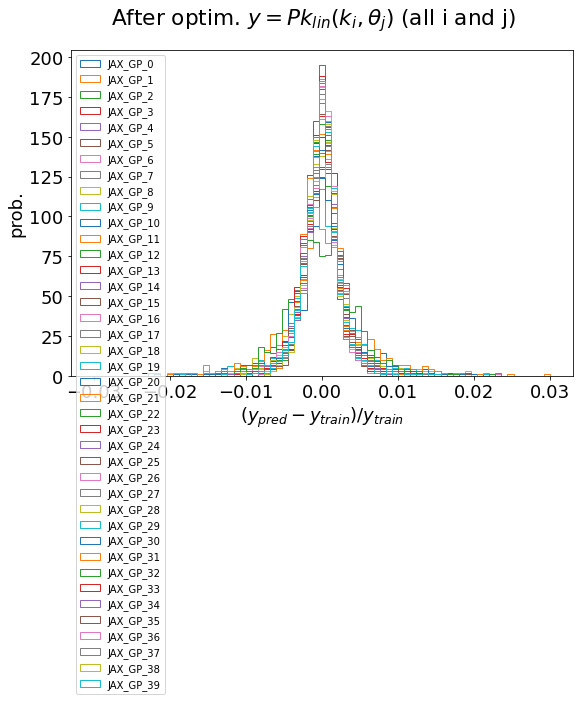

In [47]:
fig, ax = plt.subplots(figsize=(9,6))

first = True

medians = []
means = []
sigmas = []
for i_pl in range(n_pl):
    # for the time beeing re-instance the class each time
    gp_model = GPEmu(kernel=kernel_RBF,
                         order=st.order,
                         x_trans=st.x_trans,
                         y_trans=st.pl_args['y_trans'],
                         use_mean=st.use_mean)
    
    #print(f"Process GP_{i_pl}/{n_pl}")
    theta = arg_pl[i_pl][0] # cosmo \Theta_i i<N_train
    y = arg_pl[i_pl][1]     # Pk(kj,\Theta_i, z=0)
    arg_cur_gp = arg_pl[i_pl][2]
    arg_cur_gp["folder_name"] = arg_pl[i_pl][3]
    arg_cur_gp["file_name"] = arg_pl[i_pl][4]

    
    #load training 
    gp_model.load_info(arg_cur_gp["folder_name"],arg_cur_gp["file_name"])
#    print(f"GP_{i_gf}",gp_model.mean_theta, gp_model.x_trans, gp_model.transform.mu_matrix,
#          gp_model.kernel_hat, gp_model.beta_hat, gp_model.kinv_XX_res[:10],
#          gp_model.mean_function, gp_model.x_train[:10])
    
    diff = (gp_model.pred_original_function(theta)-y)/y
    
#    print('diff:',diff)
    
    medians.append(np.median(diff))
    means.append(np.mean(diff))
    sigmas.append(np.std(diff))
    
    if first:
        _,bins,_ = ax.hist(np.array(diff),bins=75, density=False, histtype='step',
                            range=[-3e-2,3e-2],label=f'JAX_GP_{i_pl}');
        first = False
    else:
        ax.hist(np.array(diff),bins=bins, density=False, histtype='step',
                            range=[-3e-2,3e-2],label=f'JAX_GP_{i_pl}');
        
    
ax.legend(loc='upper left', fontsize=10)
ax.set_xlabel(r"$(y_{pred}-y_{train})/y_{train}$");
ax.set_ylabel('prob.')    
fig.suptitle(r"After optim. $y=Pk_{lin}(k_i,\theta_j)$ (all i and j)");

In [48]:
arg_pl[0][0]

array([[0.12616742, 0.02163407, 1.18279248, 1.15724975, 0.73022459],
       [0.29972099, 0.02306631, 2.30523194, 0.86839526, 0.70286242],
       [0.13884111, 0.02485885, 1.58958545, 1.11576076, 0.76722837],
       ...,
       [0.38322584, 0.02537082, 2.92673794, 0.80712803, 0.64501174],
       [0.06389384, 0.01991875, 1.27428548, 1.28515481, 0.64342292],
       [0.2368161 , 0.02314526, 1.39656194, 0.95206408, 0.80532434]])

In [49]:
medians=np.array(medians)
sigmas=np.array(sigmas)

In [50]:
medians.shape

(40,)

In [51]:
#ks=np.linspace(st.k, st.zmax, st.nz, endpoint=True)
ks = np.geomspace(st.k_min_h_by_Mpc, st.kmax, st.nk, endpoint=True)

<ErrorbarContainer object of 3 artists>

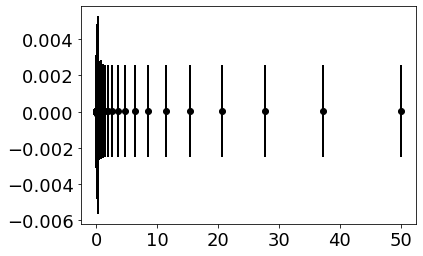

In [52]:
plt.errorbar(ks,medians,yerr=sigmas,fmt='o', linewidth=2, capsize=0, c='k', label="data")

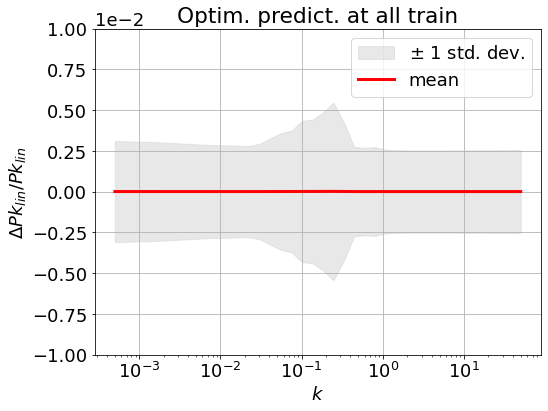

In [53]:
n_sig=1
plt.figure(figsize=(8,6))
plt.fill_between(ks,means-n_sig*sigmas,means+n_sig*sigmas, color="lightgray", 
                 label=fr"$\pm$ {n_sig} std. dev.", alpha=0.5)
plt.plot(ks,means,c='red', lw=3,label='mean')

plt.legend()
plt.xlabel(r"$k$")
plt.xscale("log")
plt.ylabel(r"$\Delta Pk_{lin}/Pk_{lin}$")
plt.ylim([-1e-2,1e-2])
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.grid()
plt.title("Optim. predict. at all train");